In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns
# ---------
from msapy import msa, utils as ut, plottings as pl
# ---------
from functools import partial
from typing import Union, Optional, List
from itertools import product
from collections import defaultdict

from IPython.display import HTML

CM = 1 / 2.54
SEED = 42
RNG = np.random.default_rng(SEED)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as dset
import torchvision.utils as vutils


from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation
torch.manual_seed(SEED)

In [4]:
# Root directory for dataset
dataroot = "~/Desktop/celebA"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [5]:
# Generator Code
class ConvTranspose2dLayer(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size = 4, stride = 1, padding = 0, output_padding = 0, groups: int = 1, bias: bool = True):
        super(ConvTranspose2dLayer, self).__init__()
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, groups, bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )
    
    def forward(self, input):
        return self.seq(input)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        first_layer = ConvTranspose2dLayer(nz, ngf * 16, 4, 1, 0, bias=False)
        middle_layers = []
        for i in range(4, 0, -1):
            middle_layers.append(ConvTranspose2dLayer(ngf * 2**(i), ngf * 2**(i-1), 4, 2, 1, bias=False))
        last_layer = nn.Sequential(nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False), nn.Sigmoid())
        self.model = nn.Sequential(first_layer, *middle_layers, last_layer)

    def forward(self, input, lesion_dict = None):
        lesion_dict = lesion_dict if lesion_dict else defaultdict(list)
        x = input
        for i, layer in enumerate(self.model):
            x = layer(x)
            if i in lesion_dict:
                x[:, lesion_dict[i]] = 0
        
        return x

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [6]:
netG = Generator(ngpu)
netG.load_state_dict(torch.load("model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
fixed_noise = torch.randn(32, nz, 1, 1)

In [8]:
import pickle as pkl

with open('save.pkl', 'rb') as fp:
    shapley_modes = pkl.load(fp)

In [9]:
lesion_dict = defaultdict(list)
for x, y in shapley_modes.columns:
    lesion_dict[x].append(y)

In [10]:
layer = 2

In [11]:
import pandas as pd
corelation_matrix = pd.DataFrame(shapley_modes[[x for x in shapley_modes.columns if x[0]==layer]]).corr()

In [15]:
import bct
from netneurotools import cluster

nonegative = np.abs(corelation_matrix.values.copy())
#nonegative = np.maximum(0, corelation_matrix.values.copy())

#ci, Q = bct.community_louvain(nonegative, gamma=1.5)
ci = [bct.community_louvain(nonegative, gamma=1.5, seed=n)[0] for n in range(100)]

consensus = cluster.find_consensus(np.column_stack(ci), seed=1234)
num_ci = len(np.unique(consensus))
y = np.bincount(consensus)
ii = np.nonzero(y)[0]
list(zip(ii,y[ii])) 

[(1, 20),
 (2, 41),
 (3, 32),
 (4, 13),
 (5, 6),
 (6, 7),
 (7, 35),
 (8, 39),
 (9, 19),
 (10, 26),
 (11, 12),
 (12, 6)]

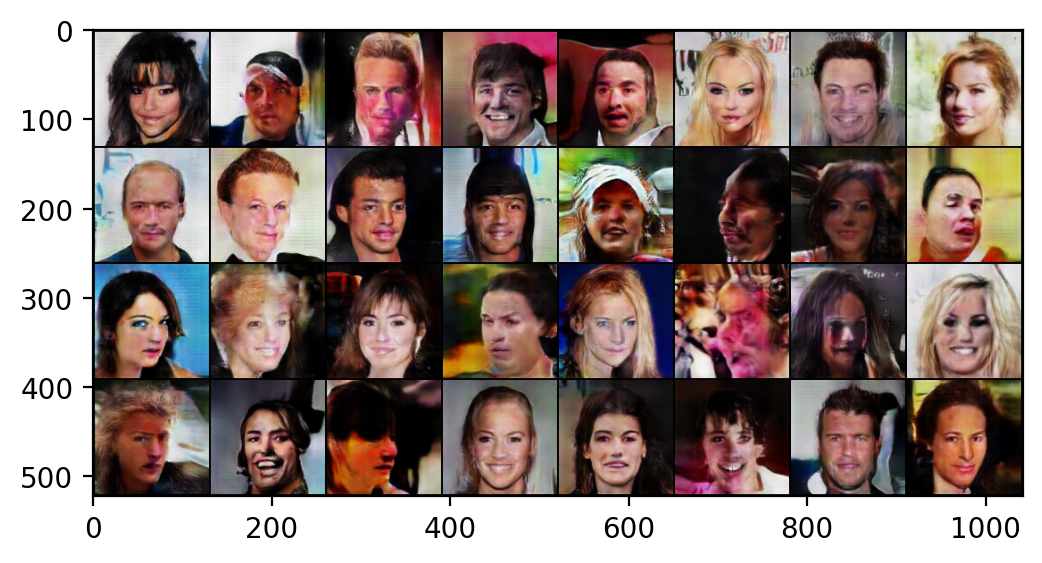

In [16]:
out = netG(fixed_noise, {})
plt.figure(dpi=200)
plt.imshow(np.transpose(vutils.make_grid(out.cpu(), padding=2),(1,2,0)))

### Details in Faces

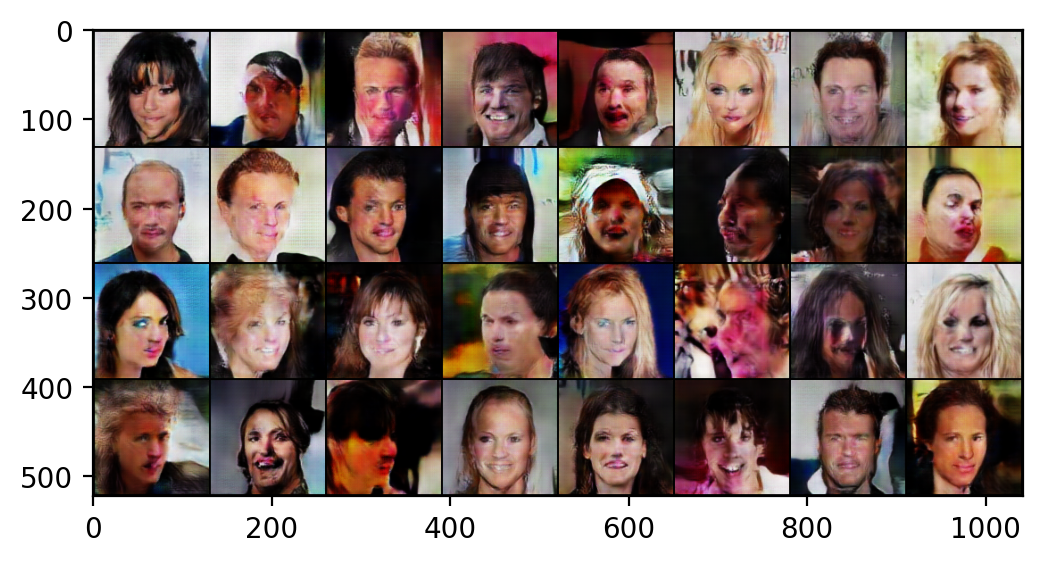

In [19]:
out = netG(fixed_noise, {layer: np.where((consensus==3))})
plt.figure(dpi=200)
plt.imshow(np.transpose(vutils.make_grid(out.cpu(), padding=2),(1,2,0)))

In [56]:
layer = 1

corelation_matrix = pd.DataFrame(shapley_modes[[x for x in shapley_modes.columns if x[0]==layer]]).corr()

nonegative = np.abs(corelation_matrix.values.copy())
#nonegative = np.maximum(0, corelation_matrix.values.copy())

#ci, Q = bct.community_louvain(nonegative, gamma=1.5)
ci = [bct.community_louvain(nonegative, gamma=1.5, seed=n)[0] for n in range(100)]

consensus = cluster.find_consensus(np.column_stack(ci), seed=1234)
num_ci = len(np.unique(consensus))
y = np.bincount(consensus)
ii = np.nonzero(y)[0]
list(zip(ii,y[ii])) 

[(1, 94),
 (2, 37),
 (3, 73),
 (4, 59),
 (5, 83),
 (6, 33),
 (7, 20),
 (8, 18),
 (9, 23),
 (10, 26),
 (11, 20),
 (12, 26)]

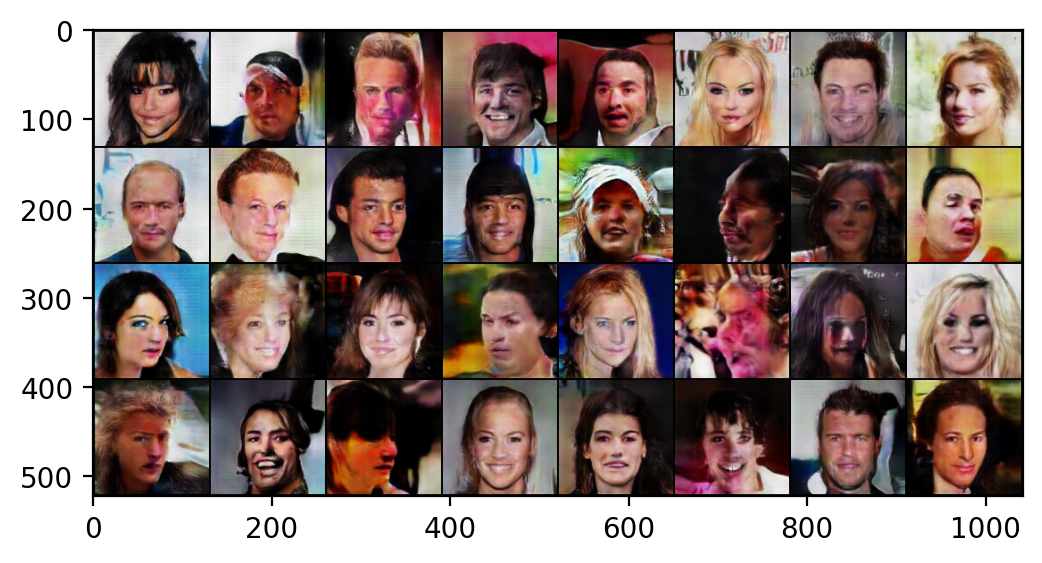

In [86]:
out = netG(fixed_noise, {})
plt.figure(dpi=200)
plt.imshow(np.transpose(vutils.make_grid(out.cpu(), padding=2),(1,2,0)))

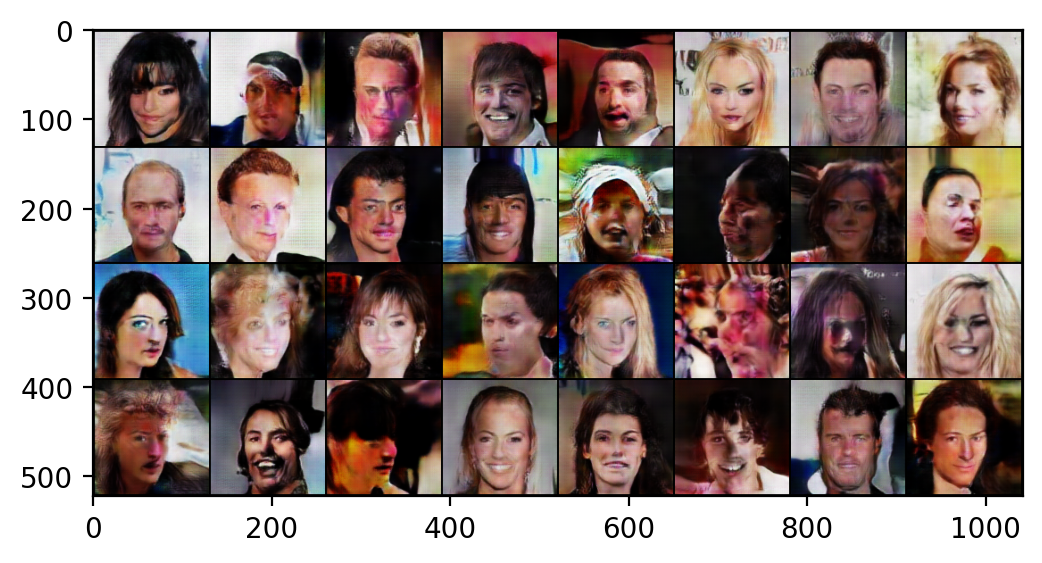

In [71]:
out = netG(fixed_noise, {layer: np.where((consensus==4))})
plt.figure(dpi=200)
plt.imshow(np.transpose(vutils.make_grid(out.cpu(), padding=2),(1,2,0)))

### Teeth Neurons

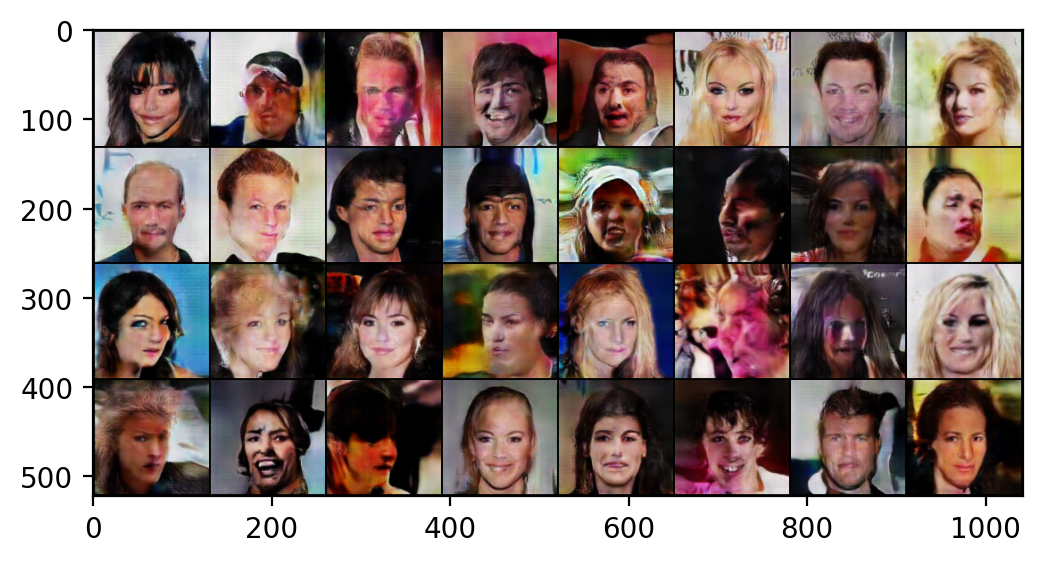

In [61]:
out = netG(fixed_noise, {layer: np.where((consensus==5))})
plt.figure(dpi=200)
plt.imshow(np.transpose(vutils.make_grid(out.cpu(), padding=2),(1,2,0)))

In [84]:
def get_layer_contributions(layer):
    layer_contrib = []
    min_val = shapley_modes.values.min()

    for x, y in shapley_modes.columns:
        if x == layer:
            layer_contrib.append(torch.Tensor(shapley_modes.get_shapley_mode((x, y))) - min_val)
    return layer_contrib

MovieWriter imagemagick unavailable; using Pillow instead.


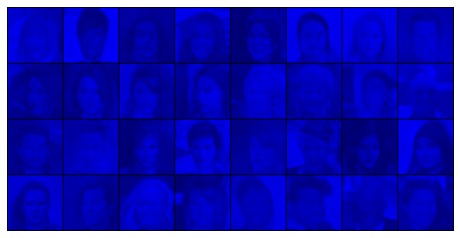

In [101]:
layer = 5

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(i), padding=2, normalize=True),(1,2,0)), animated=True)] for i in get_layer_contributions(layer)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

ani.save('animation.gif', writer='imagemagick', fps=1)

MovieWriter imagemagick unavailable; using Pillow instead.


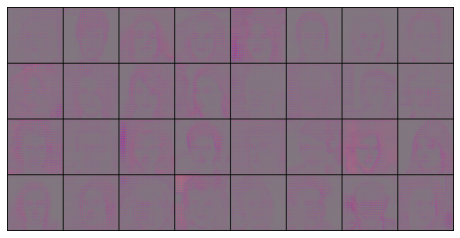

In [102]:
layer = 4

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(i), padding=2, normalize=True),(1,2,0)), animated=True)] for i in get_layer_contributions(layer)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

ani.save('animation.gif', writer='imagemagick', fps=1)

Animation size has reached 20977750 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
MovieWriter imagemagick unavailable; using Pillow instead.


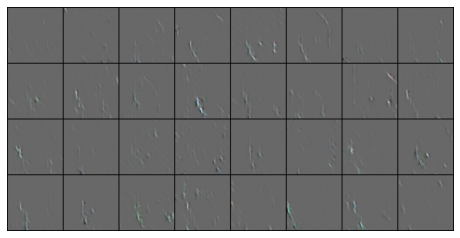

In [103]:
layer = 2

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(i), padding=2, normalize=True),(1,2,0)), animated=True)] for i in get_layer_contributions(layer)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())
ani.save('animation.gif', writer='imagemagick', fps=1)

Animation size has reached 21024381 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
MovieWriter imagemagick unavailable; using Pillow instead.


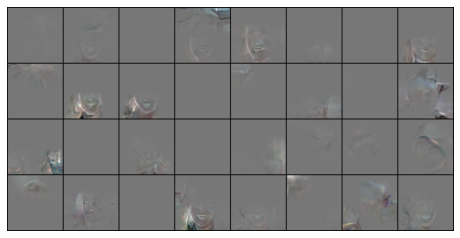

In [105]:
layer = 0

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(i), padding=2, normalize=True),(1,2,0)), animated=True)] for i in get_layer_contributions(layer)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())
ani.save('animation.gif', writer='imagemagick', fps=3)